In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats


#random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score

## 1. Data Understanding

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [3]:
train.head()

,id,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
0,0,yes,adult,530001,38.1,132.0,24.0,cool,reduced,dark_cyanotic,...,57.0,8.5,serosanguious,3.4,yes,2209,0,0,no,died
1,1,yes,adult,533836,37.5,88.0,12.0,cool,normal,pale_cyanotic,...,33.0,64.0,serosanguious,2.0,yes,2208,0,0,no,euthanized
2,2,yes,adult,529812,38.3,120.0,28.0,cool,reduced,pale_pink,...,37.0,6.4,serosanguious,3.4,yes,5124,0,0,no,lived
3,3,yes,adult,5262541,37.1,72.0,30.0,cold,reduced,pale_pink,...,53.0,7.0,cloudy,3.9,yes,2208,0,0,yes,lived
4,4,no,adult,5299629,38.0,52.0,48.0,normal,normal,normal_pink,...,47.0,7.3,cloudy,2.6,no,0,0,0,yes,lived


In [4]:
test.head()

,id,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,...,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data
0,1235,no,adult,534053,38.6,40.0,20.0,normal,normal,normal_pink,...,distend_small,42.0,7.5,clear,2.3,no,0,0,0,no
1,1236,yes,adult,528469,38.2,112.0,48.0,cool,reduced,bright_pink,...,distend_small,44.0,6.0,serosanguious,2.6,no,2208,0,0,yes
2,1237,yes,adult,528178,37.7,66.0,12.0,cool,normal,bright_red,...,distend_small,31.5,6.0,cloudy,1.6,yes,2205,0,0,yes
3,1238,no,adult,534784,37.1,88.0,20.0,cool,reduced,pale_cyanotic,...,distend_large,75.0,81.0,NaN,1.0,yes,1400,0,0,no
4,1239,yes,adult,529840,38.3,50.0,12.0,NaN,normal,bright_pink,...,distend_small,37.0,6.8,cloudy,2.6,yes,2208,0,0,yes


In [5]:
train.shape

(1235, 29)

In [6]:
sample_submission.head()

,id,outcome
0,1235,lived
1,1236,lived
2,1237,lived
3,1238,lived
4,1239,lived


In [7]:
sample_submission.shape

(824, 2)

In [8]:
train.columns

Index(['id', 'surgery', 'age', 'hospital_number', 'rectal_temp', 'pulse',
       'respiratory_rate', 'temp_of_extremities', 'peripheral_pulse',
       'mucous_membrane', 'capillary_refill_time', 'pain', 'peristalsis',
       'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux',
       'nasogastric_reflux_ph', 'rectal_exam_feces', 'abdomen',
       'packed_cell_volume', 'total_protein', 'abdomo_appearance',
       'abdomo_protein', 'surgical_lesion', 'lesion_1', 'lesion_2', 'lesion_3',
       'cp_data', 'outcome'],
      dtype='object')

In [9]:
test.columns

Index(['id', 'surgery', 'age', 'hospital_number', 'rectal_temp', 'pulse',
       'respiratory_rate', 'temp_of_extremities', 'peripheral_pulse',
       'mucous_membrane', 'capillary_refill_time', 'pain', 'peristalsis',
       'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux',
       'nasogastric_reflux_ph', 'rectal_exam_feces', 'abdomen',
       'packed_cell_volume', 'total_protein', 'abdomo_appearance',
       'abdomo_protein', 'surgical_lesion', 'lesion_1', 'lesion_2', 'lesion_3',
       'cp_data'],
      dtype='object')

In [10]:
test.shape

(824, 28)

In [11]:
train.drop(['id', 'hospital_number'], axis=1, inplace=True)
test.drop(['id', 'hospital_number'], axis=1, inplace=True)

In [12]:
test.head()

,surgery,age,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,...,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data
0,no,adult,38.6,40.0,20.0,normal,normal,normal_pink,less_3_sec,mild_pain,...,distend_small,42.0,7.5,clear,2.3,no,0,0,0,no
1,yes,adult,38.2,112.0,48.0,cool,reduced,bright_pink,more_3_sec,depressed,...,distend_small,44.0,6.0,serosanguious,2.6,no,2208,0,0,yes
2,yes,adult,37.7,66.0,12.0,cool,normal,bright_red,less_3_sec,mild_pain,...,distend_small,31.5,6.0,cloudy,1.6,yes,2205,0,0,yes
3,no,adult,37.1,88.0,20.0,cool,reduced,pale_cyanotic,less_3_sec,depressed,...,distend_large,75.0,81.0,NaN,1.0,yes,1400,0,0,no
4,yes,adult,38.3,50.0,12.0,NaN,normal,bright_pink,less_3_sec,mild_pain,...,distend_small,37.0,6.8,cloudy,2.6,yes,2208,0,0,yes


In [13]:
train.head()

,surgery,age,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
0,yes,adult,38.1,132.0,24.0,cool,reduced,dark_cyanotic,more_3_sec,depressed,...,57.0,8.5,serosanguious,3.4,yes,2209,0,0,no,died
1,yes,adult,37.5,88.0,12.0,cool,normal,pale_cyanotic,more_3_sec,mild_pain,...,33.0,64.0,serosanguious,2.0,yes,2208,0,0,no,euthanized
2,yes,adult,38.3,120.0,28.0,cool,reduced,pale_pink,less_3_sec,extreme_pain,...,37.0,6.4,serosanguious,3.4,yes,5124,0,0,no,lived
3,yes,adult,37.1,72.0,30.0,cold,reduced,pale_pink,more_3_sec,mild_pain,...,53.0,7.0,cloudy,3.9,yes,2208,0,0,yes,lived
4,no,adult,38.0,52.0,48.0,normal,normal,normal_pink,less_3_sec,alert,...,47.0,7.3,cloudy,2.6,no,0,0,0,yes,lived


In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235 entries, 0 to 1234
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surgery                1235 non-null   object 
 1   age                    1235 non-null   object 
 2   rectal_temp            1235 non-null   float64
 3   pulse                  1235 non-null   float64
 4   respiratory_rate       1235 non-null   float64
 5   temp_of_extremities    1196 non-null   object 
 6   peripheral_pulse       1175 non-null   object 
 7   mucous_membrane        1214 non-null   object 
 8   capillary_refill_time  1229 non-null   object 
 9   pain                   1191 non-null   object 
 10  peristalsis            1215 non-null   object 
 11  abdominal_distention   1212 non-null   object 
 12  nasogastric_tube       1155 non-null   object 
 13  nasogastric_reflux     1214 non-null   object 
 14  nasogastric_reflux_ph  1235 non-null   float64
 15  rect

In [15]:
train.describe()

,rectal_temp,pulse,respiratory_rate,nasogastric_reflux_ph,packed_cell_volume,total_protein,abdomo_protein,lesion_1,lesion_2,lesion_3
count,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000
mean,38.202186,79.574089,30.054251,4.382591,49.602429,21.388016,3.290931,3832.496356,14.612146,3.577328
std,0.788668,29.108638,16.452066,1.937357,10.535800,26.676453,1.589195,5436.733774,193.705735,88.858953
min,35.400000,30.000000,8.000000,1.000000,23.000000,3.500000,0.100000,0.000000,0.000000,0.000000
25%,37.800000,53.000000,18.000000,2.000000,43.000000,6.600000,2.000000,2205.000000,0.000000,0.000000
50%,38.200000,76.000000,28.000000,4.500000,48.000000,7.500000,3.000000,2209.000000,0.000000,0.000000
75%,38.600000,100.000000,36.000000,6.000000,57.000000,9.100000,4.300000,3205.000000,0.000000,0.000000
max,40.800000,184.000000,96.000000,7.500000,75.000000,89.000000,10.100000,41110.000000,3112.000000,2209.000000


Numerical values - ['rectal_temp', 'pulse', 'respiratory_rate', 'nasogastric_reflux_ph',
       'packed_cell_volume', 'total_protein', 'abdomo_protein', 'lesion_1',
       'lesion_2', 'lesion_3'] 

Categorical - ['surgery', 'age', 'temp_of_extremities', 'peripheral_pulse',
       'mucous_membrane', 'capillary_refill_time', 'pain', 'peristalsis',
       'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux',
       'rectal_exam_feces', 'abdomen', 'abdomo_appearance', 'surgical_lesion',
       'cp_data', 'outcome']


Target variable - 'outcome'

## EDA

In [16]:
cat = ['surgery', 'age', 'temp_of_extremities', 'peripheral_pulse', 'mucous_membrane', 'capillary_refill_time', 
       'pain', 'peristalsis', 'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux', 'rectal_exam_feces', 
       'abdomen', 'abdomo_appearance', 'surgical_lesion', 'cp_data', 'outcome']

for i in cat:
    print(train[i].value_counts())

surgery
yes    887
no     348
Name: count, dtype: int64
age
adult    1160
young      75
Name: count, dtype: int64
temp_of_extremities
cool      700
normal    324
cold      121
warm       51
Name: count, dtype: int64
peripheral_pulse
reduced      724
normal       429
absent        18
increased      4
Name: count, dtype: int64
mucous_membrane
pale_pink        284
normal_pink      260
pale_cyanotic    250
bright_red       211
dark_cyanotic    121
bright_pink       88
Name: count, dtype: int64
capillary_refill_time
less_3_sec    834
more_3_sec    393
3               2
Name: count, dtype: int64
pain
depressed       429
mild_pain       408
severe_pain     146
extreme_pain    120
alert            87
slight            1
Name: count, dtype: int64
peristalsis
hypomotile       664
absent           444
normal            53
hypermotile       53
distend_small      1
Name: count, dtype: int64
abdominal_distention
moderate    543
slight      346
none        212
severe      111
Name: count, dtype: int6

In [17]:
train.isnull().sum()

surgery                    0
age                        0
rectal_temp                0
pulse                      0
respiratory_rate           0
temp_of_extremities       39
peripheral_pulse          60
mucous_membrane           21
capillary_refill_time      6
pain                      44
peristalsis               20
abdominal_distention      23
nasogastric_tube          80
nasogastric_reflux        21
nasogastric_reflux_ph      0
rectal_exam_feces        190
abdomen                  213
packed_cell_volume         0
total_protein              0
abdomo_appearance         48
abdomo_protein             0
surgical_lesion            0
lesion_1                   0
lesion_2                   0
lesion_3                   0
cp_data                    0
outcome                    0
dtype: int64

In [18]:
cat_cols = train.select_dtypes(include=['object']).columns
cat_cols

Index(['surgery', 'age', 'temp_of_extremities', 'peripheral_pulse',
       'mucous_membrane', 'capillary_refill_time', 'pain', 'peristalsis',
       'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux',
       'rectal_exam_feces', 'abdomen', 'abdomo_appearance', 'surgical_lesion',
       'cp_data', 'outcome'],
      dtype='object')

In [19]:
cat_cols

Index(['surgery', 'age', 'temp_of_extremities', 'peripheral_pulse',
       'mucous_membrane', 'capillary_refill_time', 'pain', 'peristalsis',
       'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux',
       'rectal_exam_feces', 'abdomen', 'abdomo_appearance', 'surgical_lesion',
       'cp_data', 'outcome'],
      dtype='object')

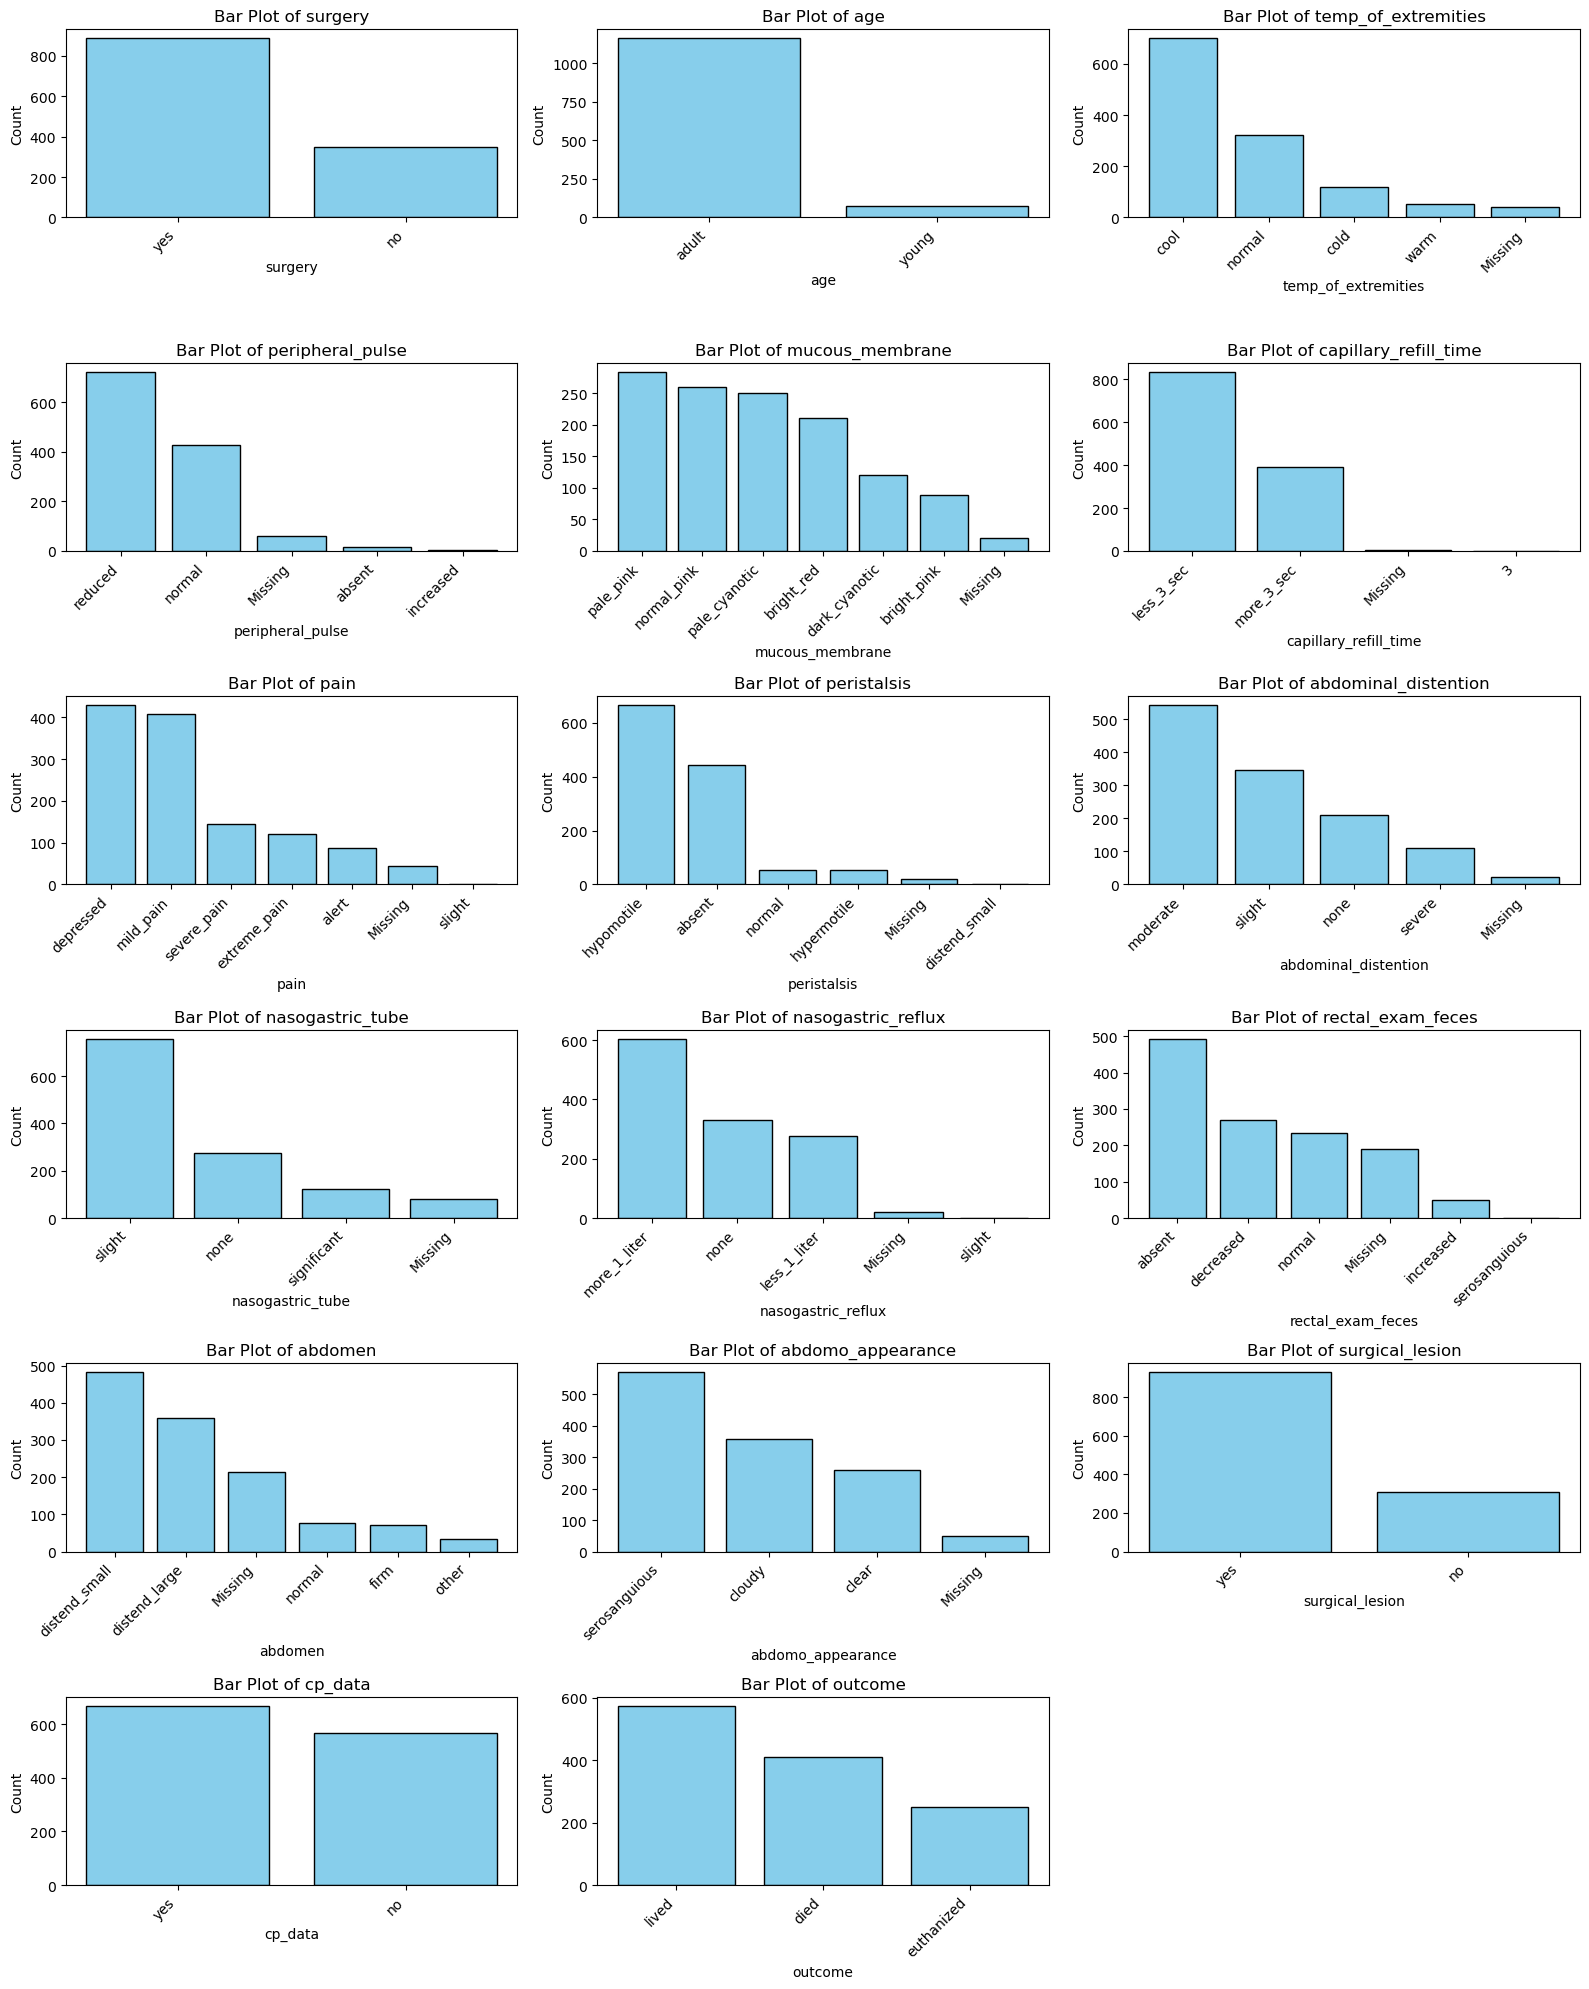

In [20]:
plt.figure(figsize=(16, 20))

for i, col in enumerate(cat_cols):
    plt.subplot(len(cat_cols) // 3 + 1, 3 , i + 1)
    #na now 'missing'
    value_counts = train[col].fillna('Missing').value_counts()
    plt.bar(value_counts.index, value_counts.values, color='skyblue', edgecolor='black')
    plt.title(f'Bar Plot of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')

    
plt.tight_layout()

plt.savefig("categorical_bar_plots.png", dpi=300, bbox_inches='tight')
plt.show()

In [21]:
num_cols = train.select_dtypes(include=['float64', 'int64']).columns
num_cols

Index(['rectal_temp', 'pulse', 'respiratory_rate', 'nasogastric_reflux_ph',
       'packed_cell_volume', 'total_protein', 'abdomo_protein', 'lesion_1',
       'lesion_2', 'lesion_3'],
      dtype='object')

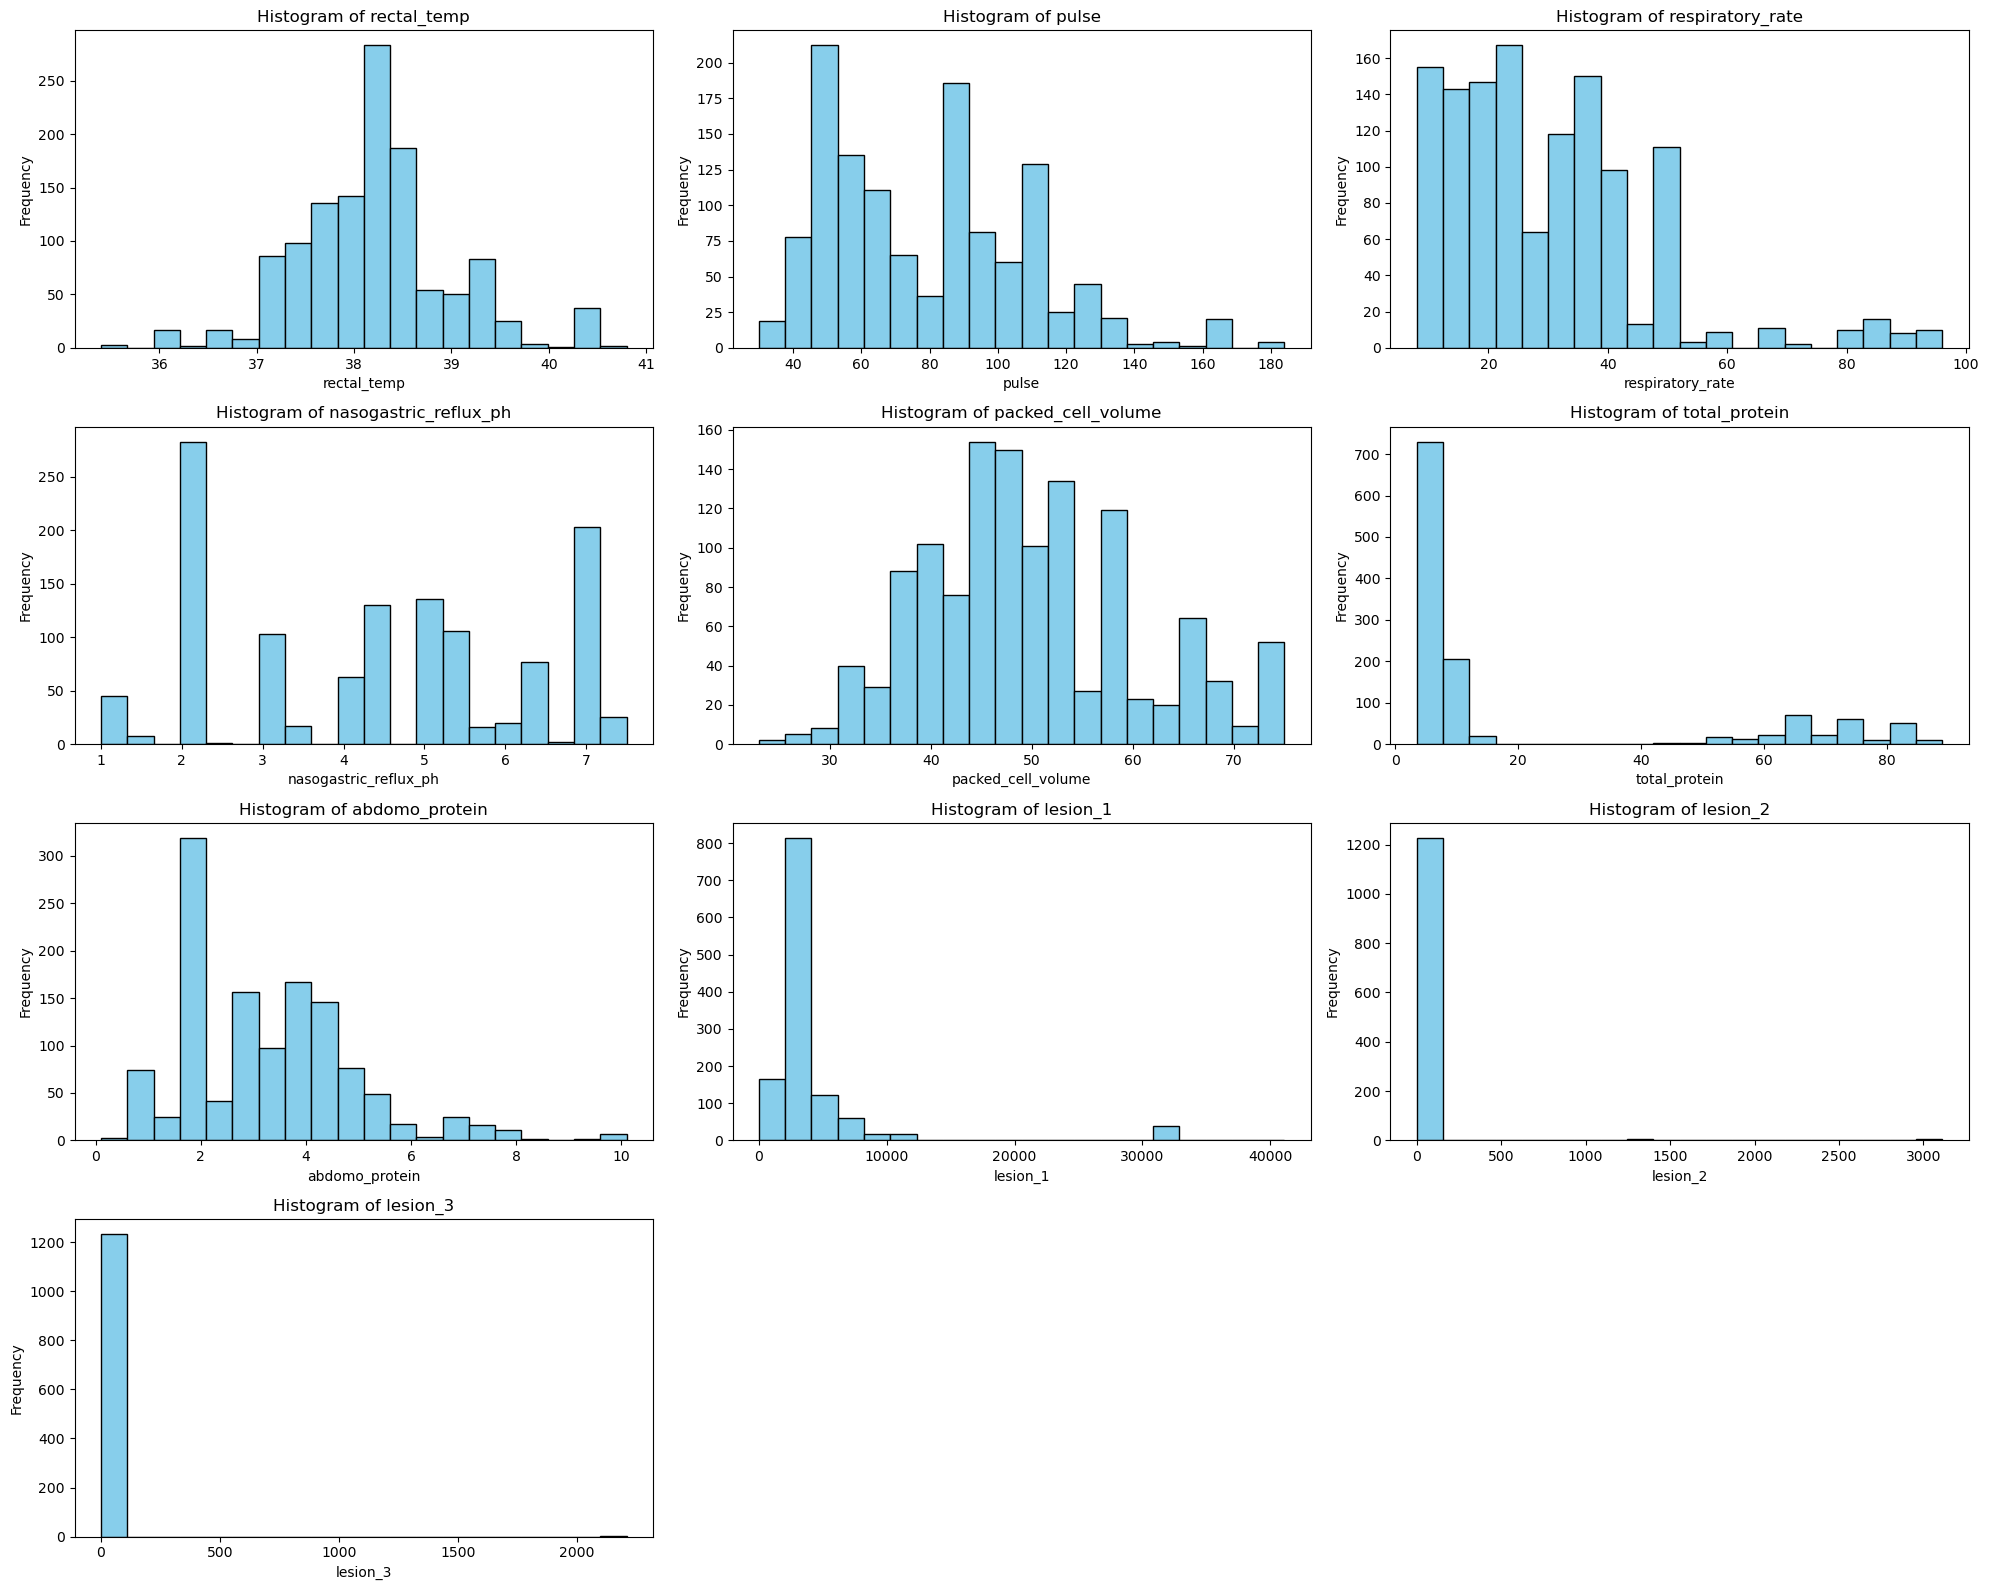

In [22]:
plt.figure(figsize=(20, 16))

for i, col in enumerate(num_cols):
    plt.subplot(len(num_cols) // 3 + 1, 3, i + 1)  #subplots in a grid
    plt.hist(train[col].dropna(), bins=20, edgecolor='black', color='skyblue')
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.savefig("num_hist.png", dpi=300, bbox_inches='tight')
plt.show()

In [23]:
import seaborn as sns

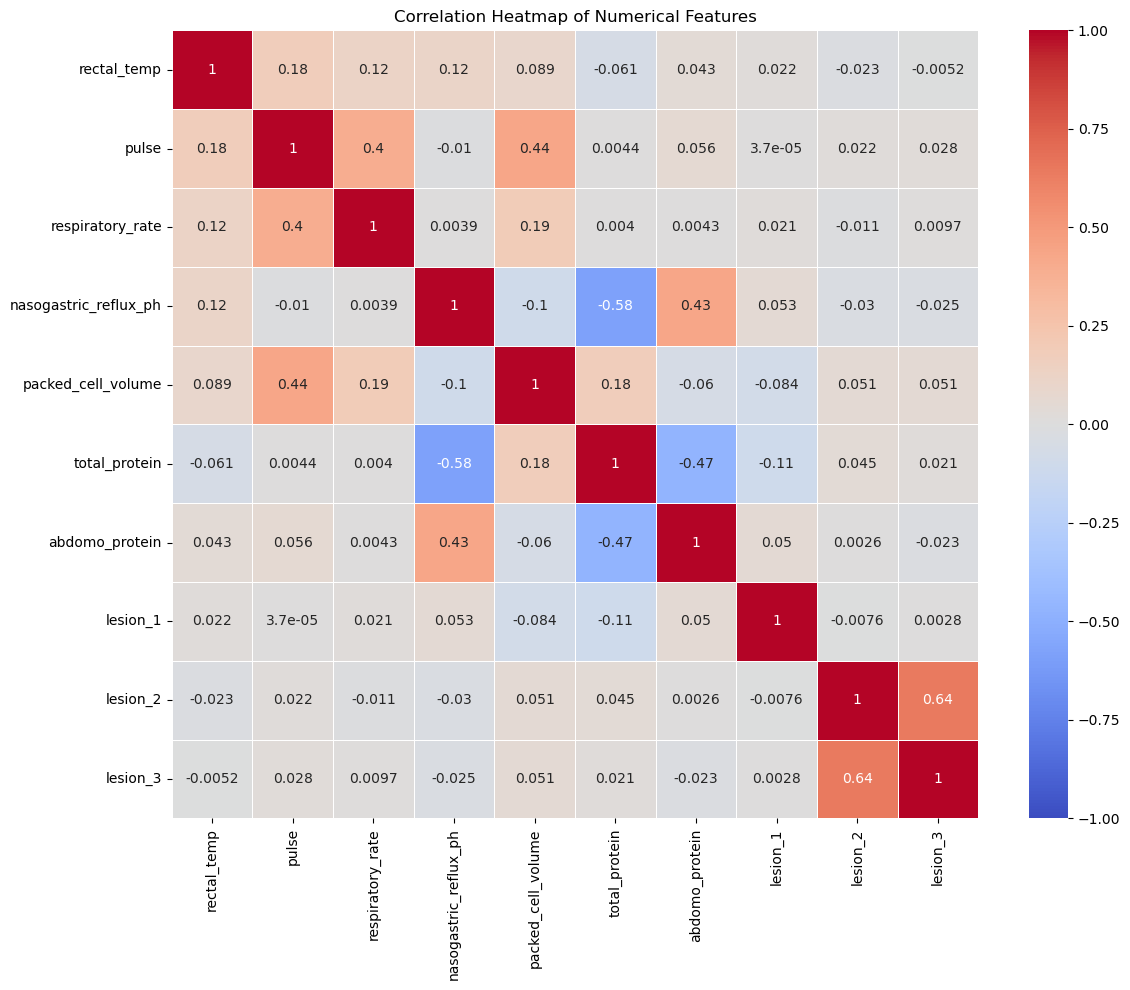

In [24]:
#num_cols = train.select_dtypes(include=['float64', 'int64']).columns
corr_matrix = train[num_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidth=.5, vmin=-1, vmax=1)

plt.xticks(ticks=np.arange(0.5, len(num_cols), 1), labels=num_cols)
plt.yticks(ticks=np.arange(0.5, len(num_cols), 1), labels=num_cols)

plt.title('Correlation Heatmap of Numerical Features')
plt.tight_layout()
plt.show()

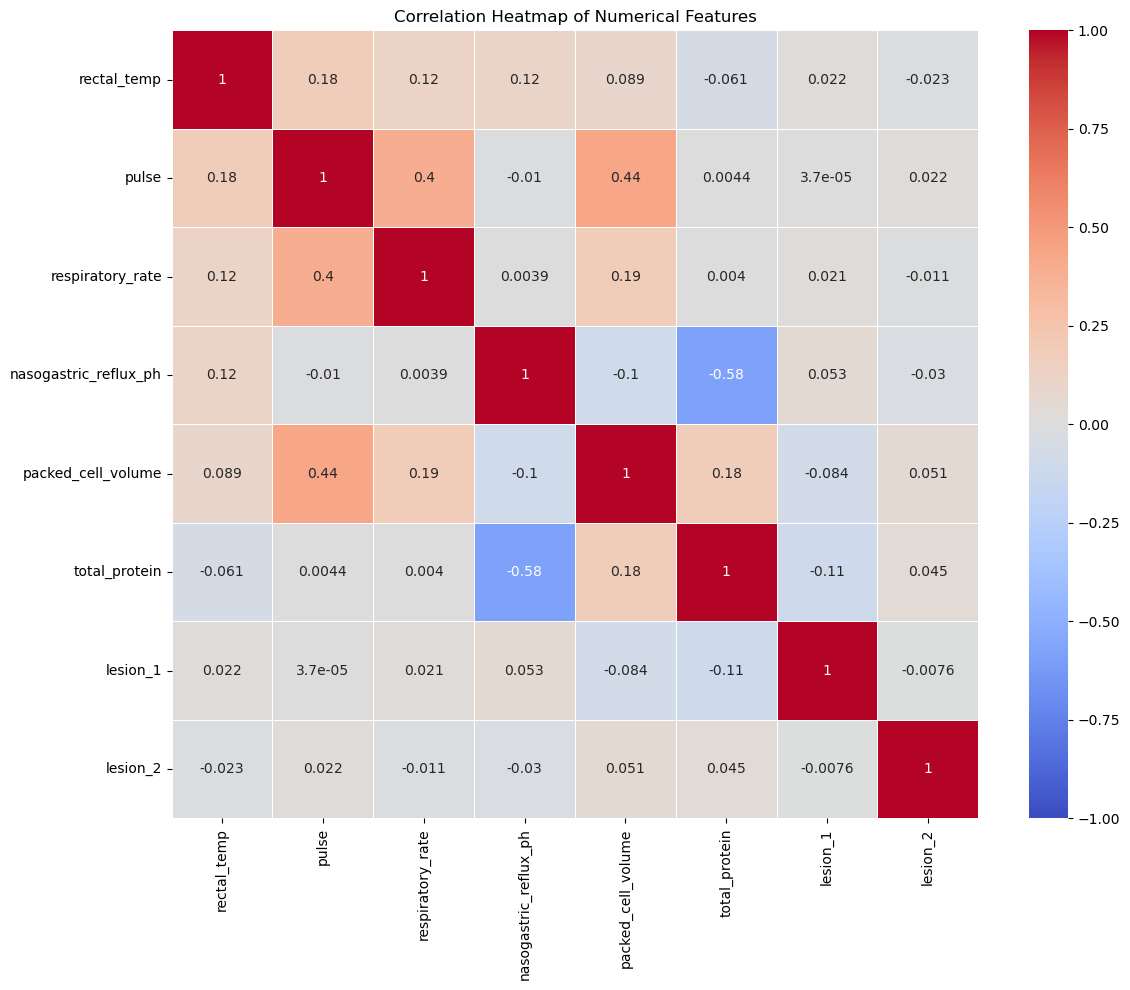

In [25]:
#let's drop some columns, lesion 3 and abdomo protein??
train = train.drop(['lesion_3', 'abdomo_protein'], axis=1)

num_cols = train.select_dtypes(include=['float64', 'int64']).columns
corr_matrix = train[num_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidth=.5, vmin=-1, vmax=1)

plt.xticks(ticks=np.arange(0.5, len(num_cols), 1), labels=num_cols)
plt.yticks(ticks=np.arange(0.5, len(num_cols), 1), labels=num_cols)

plt.title('Correlation Heatmap of Numerical Features')
plt.tight_layout()
plt.show()

# 2. Preprocessing

# How to handle missing features and categorical columns? 

Label Encoding: Assign each categorical value an integer value based on order.

One Hot Encoding: Create new variables that take on values 0 and 1 to represent the original categorical values.

In [26]:
print(cat_cols)

Index(['surgery', 'age', 'temp_of_extremities', 'peripheral_pulse',
       'mucous_membrane', 'capillary_refill_time', 'pain', 'peristalsis',
       'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux',
       'rectal_exam_feces', 'abdomen', 'abdomo_appearance', 'surgical_lesion',
       'cp_data', 'outcome'],
      dtype='object')


In [27]:
print(num_cols)
train[num_cols].isna().sum()

Index(['rectal_temp', 'pulse', 'respiratory_rate', 'nasogastric_reflux_ph',
       'packed_cell_volume', 'total_protein', 'lesion_1', 'lesion_2'],
      dtype='object')


rectal_temp              0
pulse                    0
respiratory_rate         0
nasogastric_reflux_ph    0
packed_cell_volume       0
total_protein            0
lesion_1                 0
lesion_2                 0
dtype: int64

In [28]:
train[cat_cols].isna().sum()

surgery                    0
age                        0
temp_of_extremities       39
peripheral_pulse          60
mucous_membrane           21
capillary_refill_time      6
pain                      44
peristalsis               20
abdominal_distention      23
nasogastric_tube          80
nasogastric_reflux        21
rectal_exam_feces        190
abdomen                  213
abdomo_appearance         48
surgical_lesion            0
cp_data                    0
outcome                    0
dtype: int64

In [29]:
train[cat_cols] = train[cat_cols].fillna('Missing')
train

,surgery,age,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,...,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,surgical_lesion,lesion_1,lesion_2,cp_data,outcome
0,yes,adult,38.1,132.0,24.0,cool,reduced,dark_cyanotic,more_3_sec,depressed,...,decreased,distend_small,57.0,8.5,serosanguious,yes,2209,0,no,died
1,yes,adult,37.5,88.0,12.0,cool,normal,pale_cyanotic,more_3_sec,mild_pain,...,absent,distend_small,33.0,64.0,serosanguious,yes,2208,0,no,euthanized
2,yes,adult,38.3,120.0,28.0,cool,reduced,pale_pink,less_3_sec,extreme_pain,...,Missing,distend_large,37.0,6.4,serosanguious,yes,5124,0,no,lived
3,yes,adult,37.1,72.0,30.0,cold,reduced,pale_pink,more_3_sec,mild_pain,...,decreased,distend_small,53.0,7.0,cloudy,yes,2208,0,yes,lived
4,no,adult,38.0,52.0,48.0,normal,normal,normal_pink,less_3_sec,alert,...,normal,normal,47.0,7.3,cloudy,no,0,0,yes,lived
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1230,yes,adult,38.5,129.0,48.0,cool,reduced,pale_pink,more_3_sec,depressed,...,Missing,distend_large,57.0,66.0,serosanguious,yes,2206,0,no,lived
1231,yes,adult,37.5,60.0,50.0,cool,reduced,pale_cyanotic,less_3_sec,mild_pain,...,decreased,distend_small,35.0,6.4,serosanguious,yes,2209,0,yes,died
1232,yes,young,37.5,84.0,40.0,normal,reduced,normal_pink,less_3_sec,mild_pain,...,increased,firm,40.0,5.9,cloudy,yes,400,0,yes,lived
1233,yes,adult,38.1,70.0,16.0,normal,reduced,bright_red,less_3_sec,mild_pain,...,absent,distend_small,58.0,74.0,cloudy,yes,2209,0,no,lived


In [30]:
train.isna().sum()

surgery                  0
age                      0
rectal_temp              0
pulse                    0
respiratory_rate         0
temp_of_extremities      0
peripheral_pulse         0
mucous_membrane          0
capillary_refill_time    0
pain                     0
peristalsis              0
abdominal_distention     0
nasogastric_tube         0
nasogastric_reflux       0
nasogastric_reflux_ph    0
rectal_exam_feces        0
abdomen                  0
packed_cell_volume       0
total_protein            0
abdomo_appearance        0
surgical_lesion          0
lesion_1                 0
lesion_2                 0
cp_data                  0
outcome                  0
dtype: int64

--------------------------------------------------------------

### Handling Categorical Columns

In [31]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

In [32]:
train, test= train_test_split(train, test_size=0.2, random_state=42)

In [33]:
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_train = pd.DataFrame(encoder.fit_transform(train[cat_cols]))
encoded_test = pd.DataFrame(encoder.transform(test[cat_cols]))

In [34]:
#the column names from one hot
encoded_train.columns = encoder.get_feature_names_out(cat_cols)
encoded_test.columns = encoder.get_feature_names_out(cat_cols)

In [35]:
#resetting index to concatenate 
encoded_train.reset_index(drop=True, inplace=True)
encoded_test.reset_index(drop=True, inplace=True)

In [36]:
#normalization num columns
scaler = MinMaxScaler()
train_encoded = pd.DataFrame(scaler.fit_transform(train[num_cols]), columns=num_cols)
test_encoded = pd.DataFrame(scaler.transform(test[num_cols]), columns=num_cols)

In [37]:
#resetting index
train_encoded.reset_index(drop=True, inplace=True)
test_encoded.reset_index(drop=True, inplace=True)

#concatenating the encoded categorical and normalized numerical columns
final_train = pd.concat([encoded_train, train_encoded], axis=1)
final_test = pd.concat([encoded_test, test_encoded], axis=1)

#final train df
final_train.head()

,surgery_yes,age_young,temp_of_extremities_cold,temp_of_extremities_cool,temp_of_extremities_normal,temp_of_extremities_warm,peripheral_pulse_absent,peripheral_pulse_increased,peripheral_pulse_normal,peripheral_pulse_reduced,...,outcome_euthanized,outcome_lived,rectal_temp,pulse,respiratory_rate,nasogastric_reflux_ph,packed_cell_volume,total_protein,lesion_1,lesion_2
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.666667,0.350649,0.181818,0.923077,0.224490,0.035088,0.231726,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.574074,0.233766,0.147727,0.384615,0.367347,0.047953,0.067888,0.0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.351852,0.272727,0.250000,0.153846,0.795918,0.111111,0.173578,0.0
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.500000,0.350649,0.659091,0.153846,1.000000,0.906433,0.070974,0.0
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.666667,0.194805,0.181818,0.538462,0.571429,0.059649,0.103022,0.0


In [38]:
final_test.head()

,surgery_yes,age_young,temp_of_extremities_cold,temp_of_extremities_cool,temp_of_extremities_normal,temp_of_extremities_warm,peripheral_pulse_absent,peripheral_pulse_increased,peripheral_pulse_normal,peripheral_pulse_reduced,...,outcome_euthanized,outcome_lived,rectal_temp,pulse,respiratory_rate,nasogastric_reflux_ph,packed_cell_volume,total_protein,lesion_1,lesion_2
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.740741,0.363636,0.147727,0.461538,0.448980,0.836257,0.103022,0.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.388889,0.532468,0.045455,0.153846,0.571429,0.625731,0.135166,0.0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.574074,0.272727,0.409091,0.538462,0.551020,0.059649,0.067888,0.0
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.555556,0.064935,0.090909,0.153846,0.530612,0.859649,0.071006,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.648148,0.064935,0.181818,0.661538,0.204082,0.029240,0.070910,0.0


In [39]:
final_test.columns

Index(['surgery_yes', 'age_young', 'temp_of_extremities_cold',
       'temp_of_extremities_cool', 'temp_of_extremities_normal',
       'temp_of_extremities_warm', 'peripheral_pulse_absent',
       'peripheral_pulse_increased', 'peripheral_pulse_normal',
       'peripheral_pulse_reduced', 'mucous_membrane_bright_pink',
       'mucous_membrane_bright_red', 'mucous_membrane_dark_cyanotic',
       'mucous_membrane_normal_pink', 'mucous_membrane_pale_cyanotic',
       'mucous_membrane_pale_pink', 'capillary_refill_time_Missing',
       'capillary_refill_time_less_3_sec', 'capillary_refill_time_more_3_sec',
       'pain_alert', 'pain_depressed', 'pain_extreme_pain', 'pain_mild_pain',
       'pain_severe_pain', 'pain_slight', 'peristalsis_absent',
       'peristalsis_distend_small', 'peristalsis_hypermotile',
       'peristalsis_hypomotile', 'peristalsis_normal',
       'abdominal_distention_moderate', 'abdominal_distention_none',
       'abdominal_distention_severe', 'abdominal_distention_sl

In [40]:
final_train.shape

(988, 66)

In [41]:
final_test.shape

(247, 66)

In [42]:
final_train.dtypes

surgery_yes                   float64
age_young                     float64
temp_of_extremities_cold      float64
temp_of_extremities_cool      float64
temp_of_extremities_normal    float64
                               ...   
nasogastric_reflux_ph         float64
packed_cell_volume            float64
total_protein                 float64
lesion_1                      float64
lesion_2                      float64
Length: 66, dtype: object

#### Scaled and encoded the dataframe.

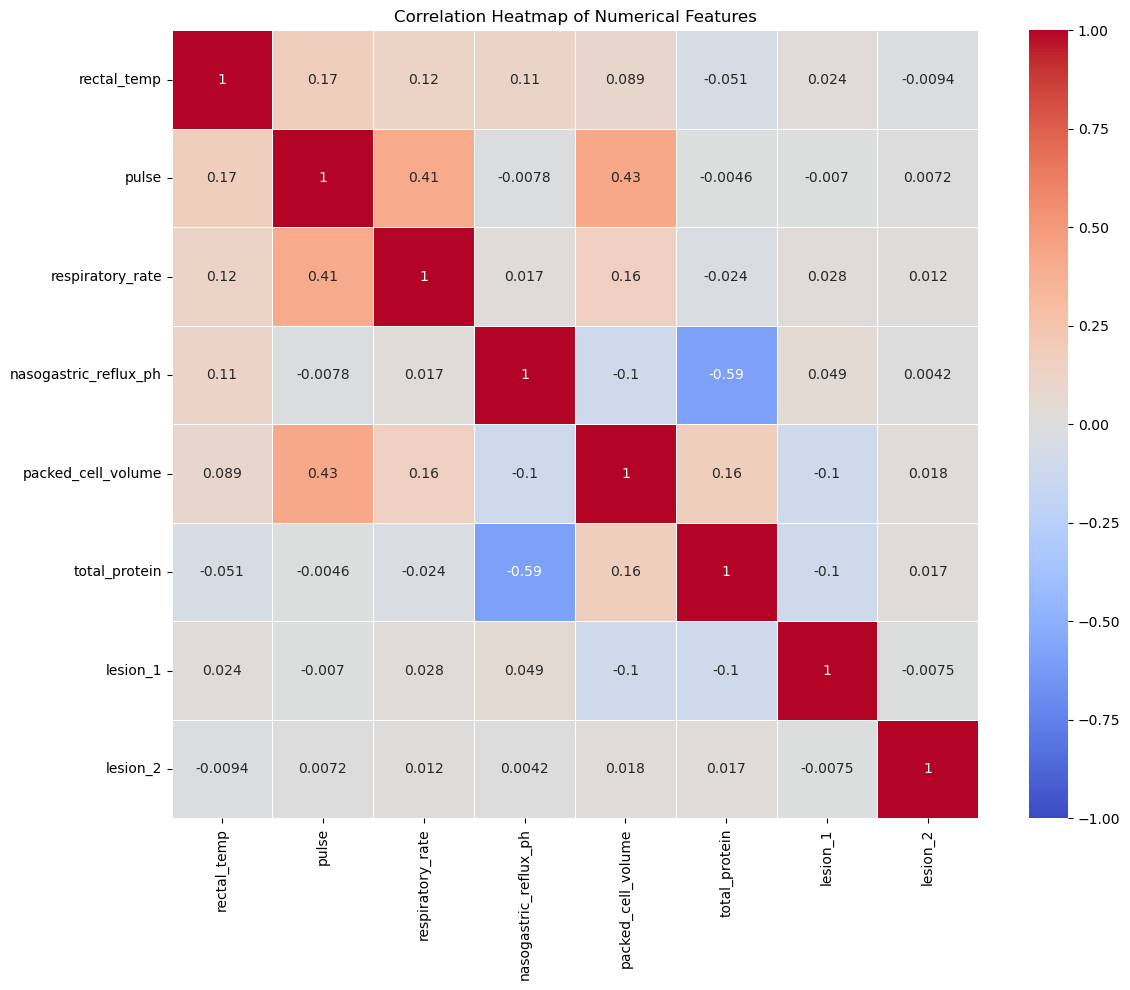

In [43]:
#num_cols = train_noncat.select_dtypes(include=['float64', 'int64']).columns
corr_matrix_final = final_train[num_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix_final, annot=True, cmap='coolwarm', linewidth=.5, vmin=-1, vmax=1)
plt.xticks(ticks=np.arange(0.5, len(num_cols), 1), labels=num_cols, rotation=90)
plt.yticks(ticks=np.arange(0.5, len(num_cols), 1), labels=num_cols)

plt.title('Correlation Heatmap of Numerical Features')
plt.tight_layout()
plt.savefig("heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

# 3. Machine Learning

In [44]:
X = final_train.drop(['outcome_euthanized', 'outcome_lived'], axis=1)
y = final_train['outcome_lived'] #'outcome_lived' as target variable

#training, validation, and test sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42) # 80% train, 20% practice valid
X_val, X_test, y_val, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=42)  #50% val/practice valid

In [45]:
rf = RandomForestClassifier(n_estimators=50, random_state=42)
rf.fit(X_train, y_train)

y_val_pred = rf.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)

val_accuracy

0.7027027027027027

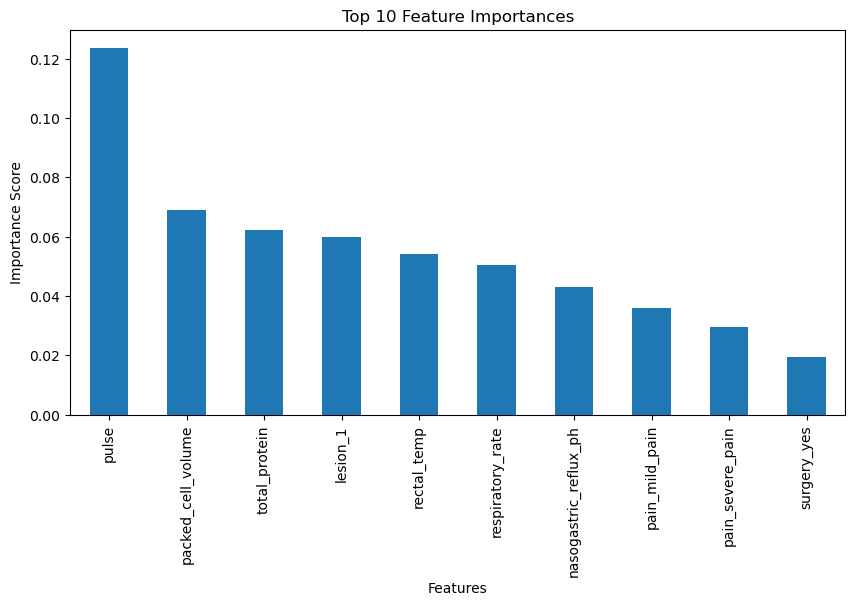

In [46]:
feature_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

feature_importances.head(10).plot(kind='bar', figsize=(10, 5))
plt.title("Top 10 Feature Importances")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.show()

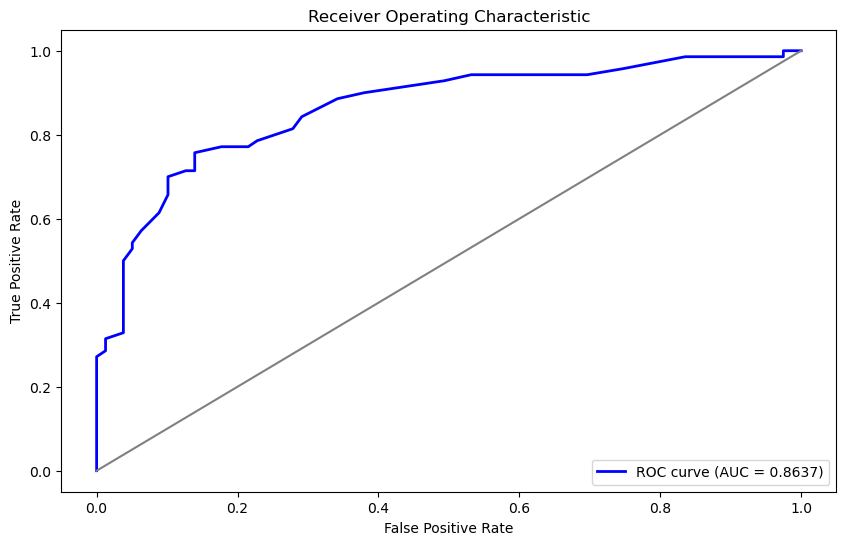

In [47]:
y_test_prob = rf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [48]:
rf = RandomForestClassifier(n_estimators=50, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.77      0.90      0.83        79
         1.0       0.86      0.70      0.77        70

    accuracy                           0.81       149
   macro avg       0.82      0.80      0.80       149
weighted avg       0.81      0.81      0.80       149



In [49]:
#let's try using k fold validation method to improve our random forest

In [50]:
scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy: {scores.mean():.2f} ± {scores.std():.2f}")

Cross-Validation Accuracy: 0.74 ± 0.03


In [51]:
param_grid = {'n_estimators': [100, 200], 'max_depth': [None, 10, 20],
              'min_samples_split': [2, 5, 10]}
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

{'max_depth': None, 'min_samples_split': 10, 'n_estimators': 100}


In [52]:
y_test_pred = rf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.2f}")

Test Accuracy: 0.81


In [53]:
#best params
final_rf = RandomForestClassifier(max_depth=None,
                                  min_samples_split=10,
                                  n_estimators=100,
                                  random_state=42)

final_rf.fit(X_train, y_train)

RandomForestClassifier(min_samples_split=10, random_state=42)

Classification Report on Test Set:

              precision    recall  f1-score   support

         0.0       0.78      0.89      0.83        79
         1.0       0.85      0.71      0.78        70

    accuracy                           0.81       149
   macro avg       0.81      0.80      0.80       149
weighted avg       0.81      0.81      0.80       149

Test AUC: 0.875


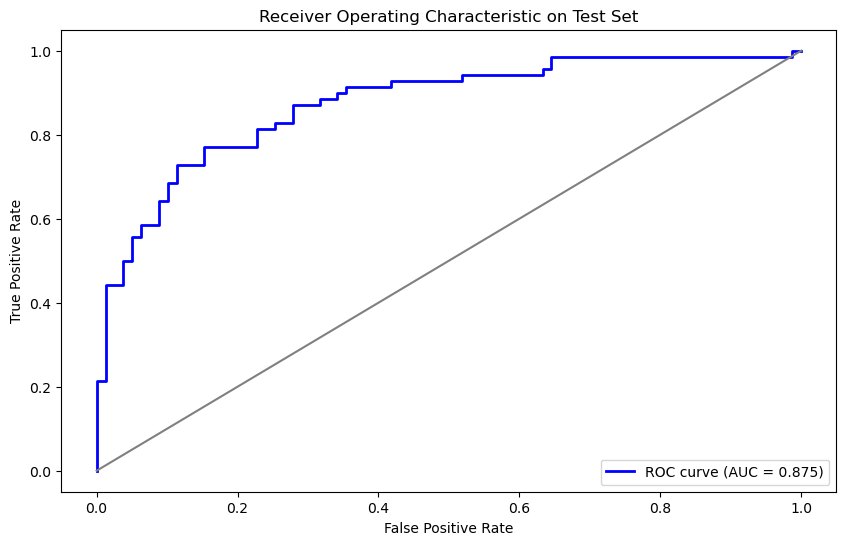

In [54]:
#predictions on the test set
y_test_pred = final_rf.predict(X_test)
y_test_prob = final_rf.predict_proba(X_test)[:, 1]

print("Classification Report on Test Set:")
print("")
print(classification_report(y_test, y_test_pred))

#AUC and ROC curve
test_auc = roc_auc_score(y_test, y_test_prob)
print(f"Test AUC: {test_auc:.3f}")

fpr, tpr, _ = roc_curve(y_test, y_test_prob)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {test_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray',)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic on Test Set')
plt.legend(loc="lower right")
plt.savefig("auc.png", dpi=300, bbox_inches='tight')
plt.show()

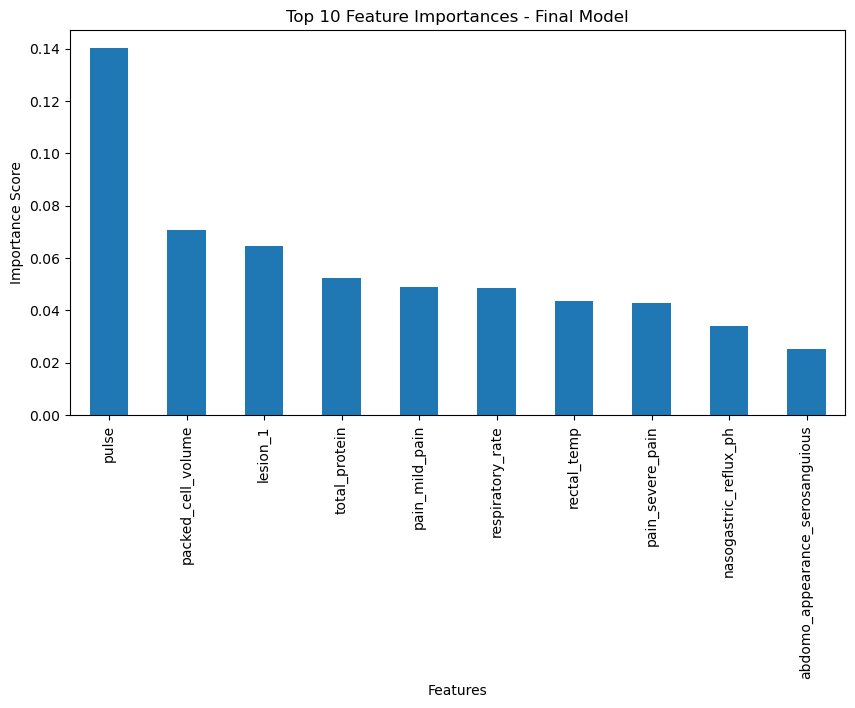

In [55]:
feature_importances = pd.Series(final_rf.feature_importances_, index=X.columns).sort_values(ascending=False)

feature_importances.head(10).plot(kind='bar', figsize=(10, 5))
plt.title("Top 10 Feature Importances - Final Model")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.savefig("top_ft.png", dpi=300, bbox_inches='tight')
plt.show()